In [1]:
from __future__ import division
import random
import math
import torch
import torchvision

from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
0: 9.871666666666666
1: 11.236666666666666
2: 9.93
3: 10.218333333333334
4: 9.736666666666666
5: 9.035
6: 9.863333333333333
7: 10.441666666666666
8: 9.751666666666667
9: 9.915000000000001
[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

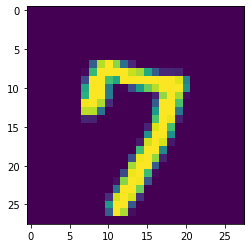

torch.Size([1, 28, 28])


In [2]:
train = datasets.MNIST("", train=True, download=True, transform = transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST("", train=False, download=True, transform = transforms.Compose([transforms.ToTensor()]))
trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True)
total = 0
counter_dict = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0 }
for data in trainset:
    Xs, ys = data
    for y in ys:
        counter_dict[int(y)] += 1
        total += 1
print(counter_dict)
for i in counter_dict:
    print(f"{i}: {counter_dict[i]/total*100}")

for data in trainset:
    print(data)
    break
x, y = data[0][0], data[1][0]
import matplotlib.pyplot as plt
plt.imshow(data[0][0].view(28,28))
plt.show()
print(data[0][0].shape)

In [3]:
class Net(nn.Module):
    def __init__(self, number_of_neurons):    
        print('inside net!')
        super().__init__()
        self.fc1 = nn.Linear(784, number_of_neurons)
        self.fc2 = nn.Linear(number_of_neurons, 10)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [4]:
class Particle:
    def __init__(self,x0):
        self.position_i=[]          # particle position
        self.velocity_i=[]          # particle velocity
        self.pos_best_i=[]          # best position individual
        self.err_best_i=-1          # best error individual
        self.err_i=-1               # error individual

    
        self.velocity_i.append(random.uniform(-1,1))
        self.position_i.append(x0)

    # evaluate current fitness
    def evaluate(self):
    	#self.err_i=costFunc(self.position_i)
        net = Net(int(round(self.position_i[0])))
    	#print(net)
        optimizer = optim.Adam(net.parameters(), lr=0.05)


        for epoch in range(3):
            for data in trainset:
                X, y = data
                net.zero_grad()
                output =  net(X.view(-1, 28*28))
                loss = F.nll_loss(output, y)
                loss.backward()
                optimizer.step()
            print('Loss',loss)
            print('Epoch', epoch)
        correct = 0
        total = 0

        with torch.no_grad():
            for data in trainset:
                X, y = data
                output = net(X.view(-1, 784))
                for idx, i in enumerate(output):
                    if torch.argmax(i) == y[idx]:
                        correct += 1
                    total += 1
        print("Accuracy", round(correct/total, 3))
        self.err_i = loss

        # check to see if the current position is an individual best
        if self.err_i < self.err_best_i or self.err_best_i==-1:
            self.pos_best_i=self.position_i
            self.err_best_i=self.err_i

    # update new particle velocity
    def update_velocity(self,pos_best_g):
        w=0.5       # constant inertia weight (how much to weigh the previous velocity)
        c1=1        # cognative constant
        c2=2        # social constant

        r1=random.random()
        r2=random.random()

        vel_cognitive=c1*r1*(self.pos_best_i[0]-self.position_i[0])
        vel_social=c2*r2*(pos_best_g[0]-self.position_i[0])
        self.velocity_i[0]=w*self.velocity_i[0]+vel_cognitive+vel_social

    # update the particle position based off new velocity updates
    def update_position(self,bounds):
        self.position_i[0]=self.position_i[0]+self.velocity_i[0]

        # adjust maximum position if necessary
        if self.position_i[0]>bounds[1]:
        	self.position_i[0]=bounds[1]

        # adjust minimum position if neseccary
        if self.position_i[0] < bounds[0]:
        	self.position_i[0]=bounds[0]

In [5]:
class PSO():
    def __init__(self,x0,bounds,num_particles,maxiter):
        global num_dimensions

        num_dimensions= 1
        err_best_g=-1                   # best error for group
        pos_best_g=[]                   # best position for group

        # establish the swarm
        swarm=[]
        for i in range(0,num_particles):
            swarm.append(Particle(x0))
        #print('Swarm : ',swarm)

        # begin optimization loop
        i=0
        while i < maxiter:
            print('Iteration :', i)
            print('*****************************')
            #print i,err_best_g
            # cycle through particles in swarm and evaluate fitness
            for j in range(0,num_particles):
                swarm[j].evaluate()
                print(j)
                #print('swarm[{}].evaluate = {}'.format(j, swarm[j].evaluate(costFunc)))

                # determine if current particle is the best (globally)
                if swarm[j].err_i < err_best_g or err_best_g == -1:
                    pos_best_g=list(swarm[j].position_i)
                    err_best_g=float(swarm[j].err_i)
                    print('pos_best_g ', pos_best_g)

            # cycle through swarm and update velocities and position
            for j in range(0,num_particles):
                swarm[j].update_velocity(pos_best_g)
                swarm[j].update_position(bounds)
            i+=1

        # print final results
        print('FINAL:')
        print(pos_best_g)
        print(err_best_g)

if __name__ == "__main__":

#--- RUN ----------------------------------------------------------------------+

    initial= 3               # initial starting location [x1,x2...]
    bounds=[1,10]  # input bounds [(x1_min,x1_max),(x2_min,x2_max)...]
    PSO(initial,bounds,num_particles=8,maxiter=10)

Iteration : 0
*****************************
inside net!
Loss tensor(1.1860, grad_fn=<NllLossBackward>)
Epoch 0
Loss tensor(1.0760, grad_fn=<NllLossBackward>)
Epoch 1
Loss tensor(1.0551, grad_fn=<NllLossBackward>)
Epoch 2
Accuracy 0.434
0
pos_best_g  [3]
inside net!
Loss tensor(1.9494, grad_fn=<NllLossBackward>)
Epoch 0
Loss tensor(2.1242, grad_fn=<NllLossBackward>)
Epoch 1
Loss tensor(2.0360, grad_fn=<NllLossBackward>)
Epoch 2
Accuracy 0.252
1
inside net!
Loss tensor(1.5278, grad_fn=<NllLossBackward>)
Epoch 0
Loss tensor(1.9347, grad_fn=<NllLossBackward>)
Epoch 1
Loss tensor(1.2146, grad_fn=<NllLossBackward>)
Epoch 2
Accuracy 0.402
2
inside net!
Loss tensor(2.0878, grad_fn=<NllLossBackward>)
Epoch 0
Loss tensor(2.0041, grad_fn=<NllLossBackward>)
Epoch 1
Loss tensor(1.6378, grad_fn=<NllLossBackward>)
Epoch 2
Accuracy 0.293
3
inside net!
Loss tensor(0.6952, grad_fn=<NllLossBackward>)
Epoch 0
Loss tensor(0.5256, grad_fn=<NllLossBackward>)
Epoch 1
Loss tensor(1.4137, grad_fn=<NllLossBackwa